# Libraries

In [137]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [138]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog as rfa, rf_tx_fw, tonegen, digital_filter_design, rx_dfe_impcomp as rx_impcomp, digital_hw_algo as dighw

reload(calc)
reload(ofdm)
reload(rfa)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(rx_impcomp)
reload(dighw)

<module 'rfdsppy.digital_hw_algo' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/digital_hw_algo.py'>

# Rect-to-polar and polar-to-rect conversions

In [139]:
# Generate sample waveform

nsym = 14
modorder = 256
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = 1
wola = 1
# sig_frac_bits = 15
# sig_power = -19
wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola)

x, x_standard = wg.generate(nsym)
cfg = wg.get_demod_params()
fs = cfg.get("fs")
wola_len = cfg.get("wola_len")

In [140]:
# Initialize CORDIC in vectoring mode

N = 10
cordic = dighw.CORDIC(N, "vectoring")
print(cordic.N)
print(cordic.mode)
print(cordic.sim_type)
print(cordic.K_)
print(cordic.theta_i_)
print(cordic.rot_mat_m_[-1])
print(cordic.rot_mat_p_[-1])

10
vectoring
vectorized
0.6072533210898753
[0.78539816 0.46364761 0.24497866 0.12435499 0.06241881 0.03123983
 0.01562373 0.00781234 0.00390623 0.00195312]
[[ 1.          0.00195312]
 [-0.00195312  1.        ]]
[[ 1.         -0.00195312]
 [ 0.00195312  1.        ]]


EVM (vectoring only): 0.0864%


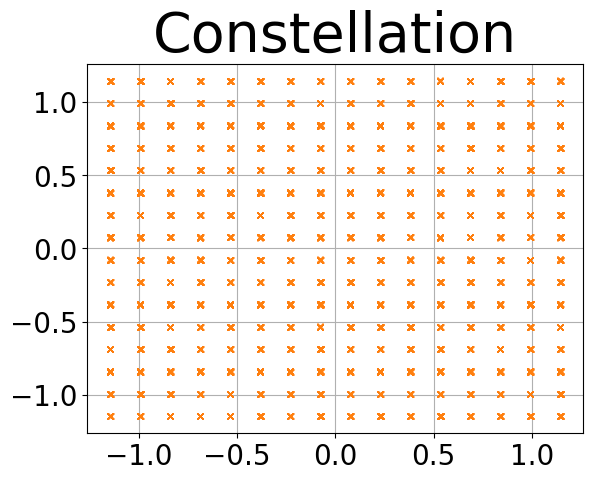

In [141]:
# Rectangular-to-polar conversion

env, ph = cordic.transform(x.real, x.imag)
x_polar = env*np.exp(1j*ph)
evm = wg.calculate_evm(x[round(wola_len/2):], x_polar[round(wola_len/2):], en_plot=True)
print(f"EVM (vectoring only): {round(evm,4)}%")

In [142]:
# Initialize CORDIC in rotation mode

cordic1 = dighw.CORDIC(N, "rotation")
print(cordic1.N)
print(cordic1.mode)
print(cordic1.sim_type)
print(cordic1.K_)
print(cordic1.theta_i_)
print(cordic1.rot_mat_m_[-1])
print(cordic1.rot_mat_p_[-1])

10
rotation
vectorized
0.6072533210898753
[0.78539816 0.46364761 0.24497866 0.12435499 0.06241881 0.03123983
 0.01562373 0.00781234 0.00390623 0.00195312]
[[ 1.          0.00195312]
 [-0.00195312  1.        ]]
[[ 1.         -0.00195312]
 [ 0.00195312  1.        ]]


Total EVM (vectoring + rotation): 0.0865%
EVM (rotation only): 0.0026%


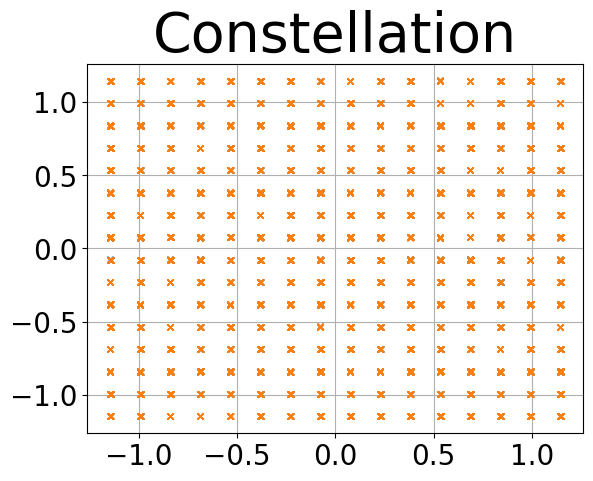

In [143]:
# Polar-to-rectangular conversion

I, Q = cordic1.transform(env, ph)
x_rect = I + 1j*Q
evm = wg.calculate_evm(x[round(wola_len/2):], x_rect[round(wola_len/2):], en_plot=False)
print(f"Total EVM (vectoring + rotation): {round(evm,4)}%")
evm = wg.calculate_evm(x_polar[round(wola_len/2):], x_rect[round(wola_len/2):], en_plot=True)
print(f"EVM (rotation only): {round(evm,4)}%")

# Phase shift

# Frequency shift

In [164]:
# Generate sample waveform

nsym = 14*10
modorder = 256
bw = 20
scs = 15
num_sc = 12
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = 1
wola = 1
# sig_frac_bits = 15
# sig_power = -19
wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola)

x, x_standard = wg.generate(nsym)
cfg = wg.get_demod_params()
fs = cfg.get("fs")
wola_len = cfg.get("wola_len")



In [184]:
# Initialize CORDIC in rotation mode

N = 4

f0 = 0.576858 # rotation frequency (MHz)
w0 = f0*2*np.pi/fs # rotation frequency (radians/sample)

theta = w0*np.arange(x.size, dtype="float")

cordic1 = dighw.CORDIC(N, "rotation", theta=theta)
cordic2 = dighw.CORDIC(N, "rotation", theta=-theta)
print(cordic1.N)
print(cordic1.mode)
print(cordic1.sim_type)
print(cordic1.theta.shape)

4
rotation
vectorized
(306760,)


EVM (shift + shift back): 1.6000044195772172e-14%


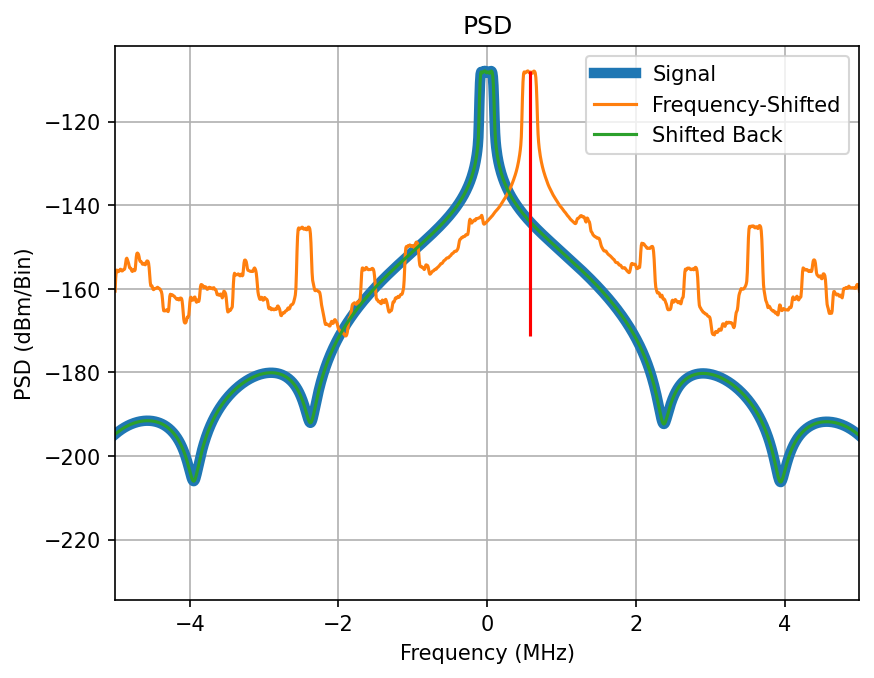

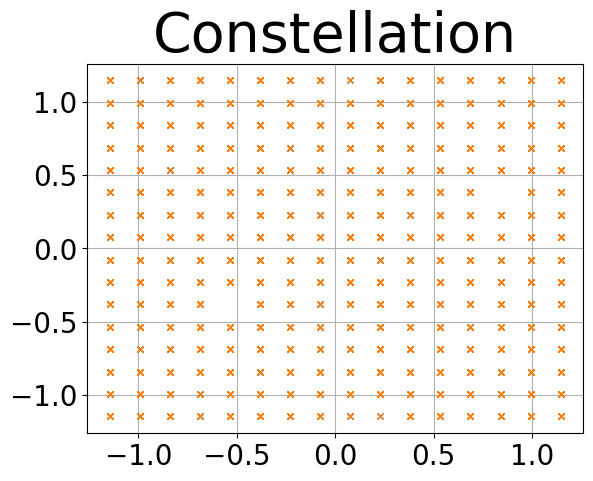

In [186]:
I, Q = cordic1.transform(x.real, x.imag)
x_fshift = I + 1j*Q

I2, Q2 = cordic2.transform(x_fshift.real, x_fshift.imag)
x_rec = I2 + 1j*Q2

py, f = calc.psd(x_fshift, fs, fs/2**12)
px, _ = calc.psd(x, fs, fs/2**12)
py2, _ = calc.psd(x_rec, fs, fs/2**12)

# fig = plt.figure()
# plt.plot(f, 10*np.log10(px), label="Signal")
# plt.plot(f, 10*np.log10(py), label="Frequency-Shifted")
# plt.title("PSD")
# plt.xlabel("Frequency (MHz)")
# plt.ylabel("PSD (dBm/Bin)")
# plt.autoscale(enable=True, axis='both', tight=True)
# plt.legend(loc="best")
# plt.grid()

fig, axs = plt.subplots(dpi=150)
py_dbm = 10*np.log10(py)
axs.plot(f, 10*np.log10(px), label="Signal", linewidth=5)
axs.plot(f, py_dbm, label="Frequency-Shifted")
axs.plot(f, 10*np.log10(py2), label="Shifted Back")
axs.set_title("PSD")
axs.set_xlabel("Frequency (MHz)")
axs.set_ylabel("PSD (dBm/Bin)")
axs.grid()
axs.legend()
axs.set_xlim(left=-5, right=5)
axs.vlines([f0], ymin=py_dbm.min(), ymax=py_dbm.max(), colors='r')

evm = wg.calculate_evm(x[round(wola_len/2):], x_rec[round(wola_len/2):], en_plot=True)
print(f"EVM (shift + shift back): {evm}%")